<a href="https://colab.research.google.com/github/eunShim/BigDataCapstone/blob/main/bigdatacapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3241415140.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


총 시도 횟수와 평균 풀이 시간 상관계수: 0.267


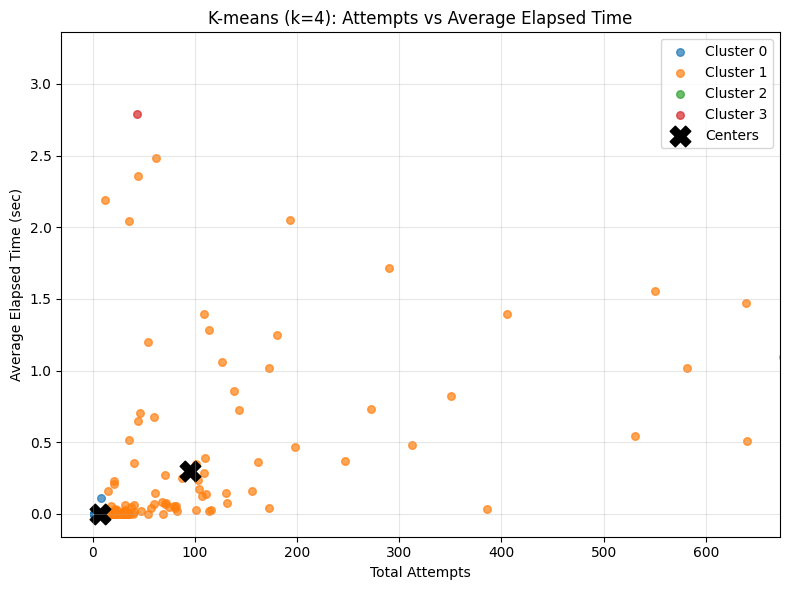

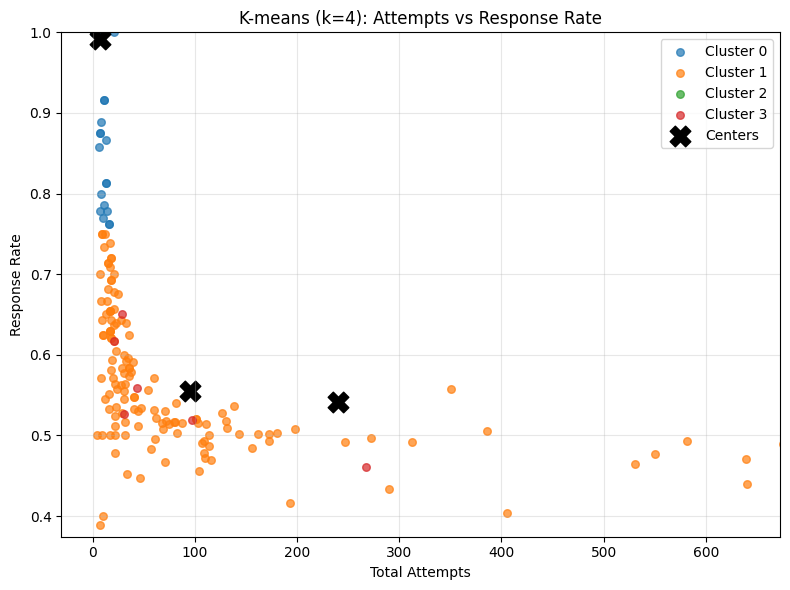

In [10]:
import zipfile
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# =======================================
# 1. ZIP에서 사용자 샘플링 (예: 500명)
# =======================================
zip_path = "/content/EdNet-KT3.zip"

with zipfile.ZipFile(zip_path, 'r') as z:
    user_files = [f for f in z.namelist() if f.startswith("KT3/") and f.endswith(".csv")]
    k = min(500, len(user_files))
    sample_files = random.sample(user_files, k)

    dfs = []
    for f in sample_files:
        with z.open(f) as fp:
            df = pd.read_csv(fp, low_memory=False)
            df["source_file"] = f.split("/")[-1].replace(".csv", "")
            dfs.append(df)

df_sample = pd.concat(dfs, ignore_index=True)

# =======================================
# 2. 사용자별 특징 추출
#    - total_attempts: submit 횟수
#    - avg_elapsed   : enter/submit 짝으로 평균 풀이시간(초)
#    - response_rate : submit/enter (0~1로 클리핑)
# =======================================
def compute_avg_elapsed(user_df):
    enter_times = user_df.loc[user_df["action_type"] == "enter", "timestamp"].reset_index(drop=True)
    submit_times = user_df.loc[user_df["action_type"] == "submit", "timestamp"].reset_index(drop=True)
    if len(enter_times) == 0 or len(submit_times) == 0:
        return np.nan
    n = min(len(enter_times), len(submit_times))
    elapsed = pd.to_datetime(submit_times[:n]) - pd.to_datetime(enter_times[:n])
    elapsed = elapsed.dt.total_seconds()
    return elapsed.mean()

user_stats = (
    df_sample.groupby("source_file")
    .apply(lambda x: pd.Series({
        "total_attempts": (x["action_type"] == "submit").sum(),
        "enter_cnt":      (x["action_type"] == "enter").sum(),
        "avg_elapsed":    compute_avg_elapsed(x)
    }))
    .reset_index()
)

# 응답률(0~1) 계산
user_stats["response_rate"] = np.where(
    user_stats["enter_cnt"] > 0,
    np.clip(user_stats["total_attempts"] / user_stats["enter_cnt"], 0, 1),
    np.nan
)

# 결측치 제거
user_stats = user_stats.dropna(subset=["avg_elapsed", "response_rate"]).reset_index(drop=True)

# =======================================
# 3. K-means 군집화 (k=4)
#    - 특성: total_attempts, avg_elapsed, response_rate
# =======================================
X = user_stats[["total_attempts", "avg_elapsed", "response_rate"]].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
user_stats["cluster"] = kmeans.fit_predict(X_scaled)

# 클러스터 중심(원 스케일) 계산
centers_scaled = kmeans.cluster_centers_
centers = pd.DataFrame(scaler.inverse_transform(centers_scaled),
                       columns=["total_attempts", "avg_elapsed", "response_rate"])

# =======================================
# 4. 상관관계(참고): 시도 vs 시간
# =======================================
corr = user_stats[["total_attempts", "avg_elapsed"]].corr().iloc[0, 1]
print(f"총 시도 횟수와 평균 풀이 시간 상관계수: {corr:.3f}")

# =======================================
# 5. 시각화 도우미: 축 범위를 분위수 기반으로 자동 설정
# =======================================
def auto_limits(series, q_low=1, q_high=99, pad_ratio=0.05):
    lo = np.nanpercentile(series, q_low)
    hi = np.nanpercentile(series, q_high)
    if hi == lo:
        lo = series.min()
        hi = series.max()
    pad = (hi - lo) * pad_ratio
    return lo - pad, hi + pad

# =======================================
# 6. Visualization 1: Attempts vs Avg Elapsed
# =======================================
plt.figure(figsize=(8, 6))
for c in sorted(user_stats["cluster"].unique()):
    part = user_stats[user_stats["cluster"] == c]
    plt.scatter(part["total_attempts"], part["avg_elapsed"],
                s=30, alpha=0.7, label=f"Cluster {c}")

plt.xlim(auto_limits(user_stats["total_attempts"]))
plt.ylim(auto_limits(user_stats["avg_elapsed"]))

plt.scatter(centers["total_attempts"], centers["avg_elapsed"],
            c="black", s=220, marker="X", label="Centers")

plt.xlabel("Total Attempts")
plt.ylabel("Average Elapsed Time (sec)")
plt.title("K-means (k=4): Attempts vs Average Elapsed Time")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =======================================
# 7. Visualization 2: Attempts vs Response Rate
# =======================================
plt.figure(figsize=(8, 6))
for c in sorted(user_stats["cluster"].unique()):
    part = user_stats[user_stats["cluster"] == c]
    plt.scatter(part["total_attempts"], part["response_rate"],
                s=30, alpha=0.7, label=f"Cluster {c}")

plt.xlim(auto_limits(user_stats["total_attempts"]))
ylo, yhi = auto_limits(user_stats["response_rate"])
plt.ylim((max(0.0, ylo), min(1.0, yhi)))

plt.scatter(centers["total_attempts"], centers["response_rate"],
            c="black", s=220, marker="X", label="Centers")

plt.xlabel("Total Attempts")
plt.ylabel("Response Rate")
plt.title("K-means (k=4): Attempts vs Response Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
